#notebook setup

In [1]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [2]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 37kB/s 
     |████████████████████████████████| 3.8MB 61.3MB/s 
     |████████████████████████████████| 450kB 57.5MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc', 'loss']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [7]:
%cd drive/'My Drive/CMS'
!pwd

/content/drive/My Drive/CMS
/content/drive/My Drive/CMS


In [8]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [9]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/CMS/filtered_images/0/...      0
1  /content/drive/My Drive/CMS/filtered_images/0/...      0
2  /content/drive/My Drive/CMS/filtered_images/0/...      0
3  /content/drive/My Drive/CMS/filtered_images/2/...      2
4  /content/drive/My Drive/CMS/filtered_images/0/...      0
3600


filename    object
class        int64
dtype: object

In [10]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [11]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [16]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# VGG16

## Entirely frozen

In [17]:
base_vgg16_0 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

58892288/58889256 [==============================] - 5s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_vgg16_0.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
base_vgg16_model = Model(inputs=base_vgg16_0.input, outputs=predictions)

In [20]:
for layer in base_vgg16_0.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [21]:
for layer in base_vgg16_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dropout  Trainable = True
dense_1  Trainable = True
dropout_1  Trainable = True
dense_2  Trainable = True
dropout_2  Trainable = True
dense_3  Trainable = True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
opt1 = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
base_vgg16_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [23]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

base_vgg16_model_filepath = 'entirely_frozen_vgg16_rmsprop.h5'
mcp = ModelCheckpoint(base_vgg16_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_vgg16_history = base_vgg16_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 1795s 75s/step - loss: 1.6701 - accuracy: 0.4323 - val_loss: 0.6843 - val_accuracy: 0.6556
Epoch 2/50
24/24 [==============================] - 13s 532ms/step - loss: 1.1086 - accuracy: 0.5660 - val_loss: 0.6302 - val_accuracy: 0.6806
Epoch 3/50
24/24 [==============================] - 13s 557ms/step - loss: 0.9456 - accuracy: 0.6066 - val_loss: 0.5849 - val_accuracy: 0.7167
Epoch 4/50
24/24 [==============================] - 13s 525ms/step - loss: 0.8155 - accuracy: 0.6361 - val_loss: 0.5617 - val_accuracy: 0.7417
Epoch 5/50
24/24 [==============================] - 14s 568ms/step - loss: 0.7668 - accuracy: 0.6576 - val_loss: 0.5628 - val_accuracy: 0.7528
Epoch 6/50
24/24 [==============================] - 13s 561ms/step - loss: 0.7165 - accuracy: 0.6788 - val_loss: 0.5471 - val_accuracy: 0.7667
Epoch 7/50
24/24 [==============================] - 12s 514ms/step - los

#### testing the model

In [24]:
test_steps = int(len(df_test)/batch_size)

metrics = base_vgg16_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 202s 67s/step - loss: 0.4923 - accuracy: 0.7806
model accuracy: 0.78055555


#### plotting training

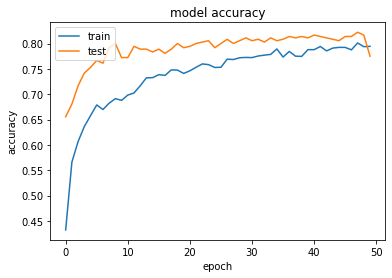

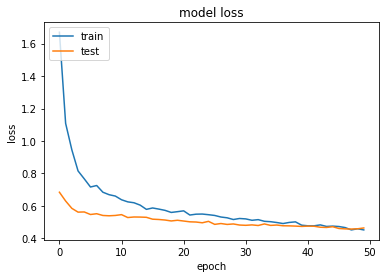

In [25]:
plot_hist(entirely_frozen_vgg16_history, 'entirely_frozen_vgg16_rmsprop')

#### saving the history of the fitting

In [26]:

with open(cwd + '/trainHistoryDict/entirely_frozen_vgg16_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_vgg16_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
base_vgg16_1 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_vgg16_1.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_vgg16_model = Model(inputs=base_vgg16_1.input, outputs=predictions)

In [30]:
for layer in base_vgg16_1.layers:
    print(layer.name)
    layer.trainable = False

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [31]:
trainable_count = 0
per_layers = 0.2
num_model_layers = len(base_vgg16_1.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.21052631578947367


In [0]:

set_trainable = False
for idx, layer in enumerate(base_vgg16_1.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False


In [33]:
for layer in few_unfrozen_vgg16_model.layers:
    print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d_1 True
dense_4 True
dropout_3 True
dense_5 True
dropout_4 True
dense_6 True
dropout_5 True
dense_7 True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_vgg16_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [35]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'few_unfrozen_vgg16_rmsprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_vgg16_history = few_unfrozen_vgg16_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 14s 587ms/step - loss: 0.9361 - accuracy: 0.5573 - val_loss: 0.5844 - val_accuracy: 0.7194
Epoch 2/50
24/24 [==============================] - 13s 542ms/step - loss: 0.6499 - accuracy: 0.6997 - val_loss: 0.6161 - val_accuracy: 0.7139
Epoch 3/50
24/24 [==============================] - 14s 584ms/step - loss: 0.6207 - accuracy: 0.7302 - val_loss: 0.4872 - val_accuracy: 0.8139
Epoch 4/50
24/24 [==============================] - 13s 547ms/step - loss: 0.5823 - accuracy: 0.7462 - val_loss: 0.5147 - val_accuracy: 0.7722
Epoch 5/50
24/24 [==============================] - 14s 577ms/step - loss: 0.5730 - accuracy: 0.7576 - val_loss: 0.5765 - val_accuracy: 0.7917
Epoch 6/50
24/24 [==============================] - 13s 543ms/step - loss: 0.5400 - accuracy: 0.7760 - val_loss: 0.4846 - val_accuracy: 0.7889
Epoch 7/50
24/24 [==============================] - 14s 584ms/step - los

#### testing the model

In [36]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_vgg16_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 461ms/step - loss: 2.8296 - accuracy: 0.7611
model accuracy: 0.76111114


#### plotting training

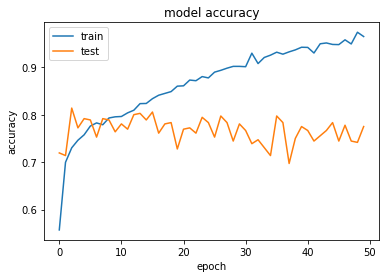

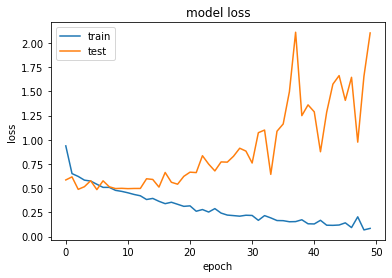

In [37]:
plot_hist(few_unfrozen_vgg16_history, 'few_unfrozen_vgg16_rmsprop')

#### saving the history of the fitting

In [38]:
with open(cwd + '/trainHistoryDict/few_unfrozen_vgg16_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_vgg16_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
base_vgg16_2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_vgg16_2.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_vgg16_model = Model(inputs=base_vgg16_2.input, outputs=predictions)

In [44]:
for layer in base_vgg16_2.layers:
    print(layer.name)
    layer.trainable = False

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [45]:
trainable_count = 0
per_layers = 0.7
num_model_layers = len(base_vgg16_2.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.7368421052631579


In [0]:
set_trainable = False
for idx, layer in enumerate(base_vgg16_2.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

In [47]:
for layer in many_unfrozen_vgg16_model.layers:
    print(layer.name,layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d_2 True
dense_8 True
dropout_6 True
dense_9 True
dropout_7 True
dense_10 True
dropout_8 True
dense_11 True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_vgg16_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [49]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'many_unfrozen_vgg16_rmsprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
many_unfrozen_vgg16_history = many_unfrozen_vgg16_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 21s 891ms/step - loss: 1.2984 - accuracy: 0.3455 - val_loss: 1.0931 - val_accuracy: 0.4306
Epoch 2/50
24/24 [==============================] - 20s 831ms/step - loss: 1.1410 - accuracy: 0.3535 - val_loss: 1.0798 - val_accuracy: 0.3250
Epoch 3/50
24/24 [==============================] - 18s 758ms/step - loss: 1.1975 - accuracy: 0.3503 - val_loss: 1.0572 - val_accuracy: 0.3417
Epoch 4/50
24/24 [==============================] - 18s 754ms/step - loss: 1.1010 - accuracy: 0.3493 - val_loss: 1.0971 - val_accuracy: 0.3694
Epoch 5/50
24/24 [==============================] - 18s 760ms/step - loss: 1.0962 - accuracy: 0.3382 - val_loss: 1.0974 - val_accuracy: 0.3083
Epoch 6/50
24/24 [==============================] - 20s 835ms/step - loss: 1.0871 - accuracy: 0.3740 - val_loss: 1.0988 - val_accuracy: 0.3472
Epoch 7/50
24/24 [==============================] - 18s 763ms/step - los

#### testing the model

In [50]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_vgg16_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 467ms/step - loss: 1.0997 - accuracy: 0.2833
model accuracy: 0.28333333


#### plotting training

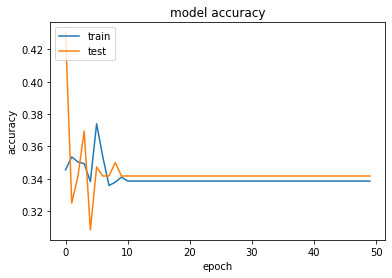

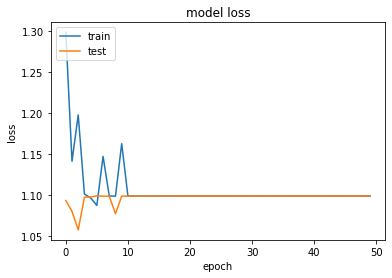

In [51]:
plot_hist(many_unfrozen_vgg16_history, 'many_unfrozen_vgg16_rmsprop')

#### saving the history of the fitting

In [52]:
with open(cwd + '/trainHistoryDict/many_unfrozen_vgg16_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_vgg16_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
input_shapes = (200, 200, 3)
base_vgg16_3 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shapes,pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_vgg16_3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_vgg16_model = Model(inputs=base_vgg16_3.input, outputs=predictions)

In [56]:
for layer in unfrozen_vgg16_model.layers:
    print(layer.name)
    layer.trainable = True

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_3
dense_12
dropout_9
dense_13
dropout_10
dense_14
dropout_11
dense_15


In [57]:
for layer in unfrozen_vgg16_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_4  Trainable = True
block1_conv1  Trainable = True
block1_conv2  Trainable = True
block1_pool  Trainable = True
block2_conv1  Trainable = True
block2_conv2  Trainable = True
block2_pool  Trainable = True
block3_conv1  Trainable = True
block3_conv2  Trainable = True
block3_conv3  Trainable = True
block3_pool  Trainable = True
block4_conv1  Trainable = True
block4_conv2  Trainable = True
block4_conv3  Trainable = True
block4_pool  Trainable = True
block5_conv1  Trainable = True
block5_conv2  Trainable = True
block5_conv3  Trainable = True
block5_pool  Trainable = True
global_average_pooling2d_3  Trainable = True
dense_12  Trainable = True
dropout_9  Trainable = True
dense_13  Trainable = True
dropout_10  Trainable = True
dense_14  Trainable = True
dropout_11  Trainable = True
dense_15  Trainable = True


In [58]:
unfrozen_vgg16_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
opt1 = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_vgg16_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [60]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'unfrozen_vgg16_rmsprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_vgg16_history = unfrozen_vgg16_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 26s 1s/step - loss: 1.2218 - accuracy: 0.3514 - val_loss: 1.0947 - val_accuracy: 0.3639
Epoch 2/50
24/24 [==============================] - 24s 1s/step - loss: 1.3049 - accuracy: 0.3872 - val_loss: 1.0501 - val_accuracy: 0.5139
Epoch 3/50
24/24 [==============================] - 24s 1s/step - loss: 1.0368 - accuracy: 0.5201 - val_loss: 0.6430 - val_accuracy: 0.6389
Epoch 4/50
24/24 [==============================] - 25s 1s/step - loss: 0.8755 - accuracy: 0.5545 - val_loss: 0.6385 - val_accuracy: 0.6306
Epoch 5/50
24/24 [==============================] - 24s 1s/step - loss: 0.7381 - accuracy: 0.6080 - val_loss: 0.5514 - val_accuracy: 0.7778
Epoch 6/50
24/24 [==============================] - 24s 1s/step - loss: 0.7769 - accuracy: 0.6299 - val_loss: 0.5558 - val_accuracy: 0.7444
Epoch 7/50
24/24 [==============================] - 24s 1s/step - loss: 0.6368 - accuracy:

#### testing the model

In [61]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_vgg16_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 449ms/step - loss: 1.5732 - accuracy: 0.7667
model accuracy: 0.76666665


#### plotting training

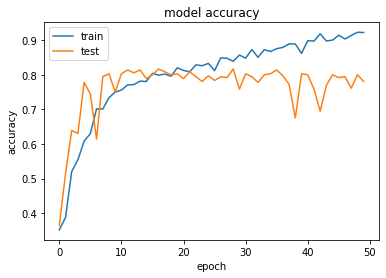

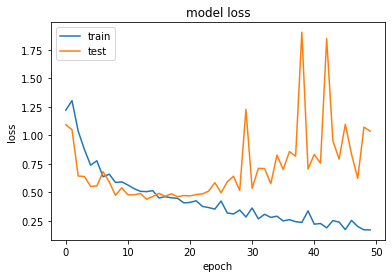

In [62]:
plot_hist(unfrozen_vgg16_history, 'unfrozen_vgg16_rmsprop')

#### saving the history of the fitting

In [63]:
with open(cwd + '/trainHistoryDict/unfrozen_vgg16_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(unfrozen_vgg16_history.history, file_pi)
print('history saved')

history saved
